# Stock Buying Detection with Machine Learning Algorithms

## Introduction
In this notebook, I'll explore various machine learning algorithms to predict optimal times for buying stocks.
The goal is to identify patterns and create a predictive model that suggests favorable moments for stock purchases based on historical data.

## Data Source
I'll be using historical stock market data obtained from yfinance.
For the training data, I will use stock data of 50 companies between the years 2013-2019
For the testing dataset, I will use Apple stock in 2020

## The Idea
we will mark day points of a stock with 0 or 1 label.
0 zero means hold and 1 label means buy.
The idea is that I want to find only buy points, since I will have risk management to the stock and my selling points will be depent on the loss or earned after the initial buy

## Steps
1. **Data Preprocessing**: Cleaning, normalization, and feature engineering - 
    In the Data_utils.py file, I built a data class that extracts features and labels entry points to the stock for our model.
    The features are technical analysis features together with trend patterns like moving averages and others.
2. **Model Selection**: Testing different ML algorithms:
    - logistic Regression
    - Random Forest
    - Neural Networks
3. **Model Evaluation**: Assessing model performance using relevant metrics.
4. **Conclusion**: Summarizing findings and suggesting the most effective model for stock buying detection.


# Importing libaries and building train and test dataset


In [2]:
import Data_Utils
import numpy as np
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import nn_model
import torch

# Train dataset

In [3]:
stocks = [
        "AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "BABA", "TCEHY", "005930.KS",
        "ASML", "INTC", "ADBE", "NFLX", "PYPL", "CRM", "ORCL", "SHOP", "ACN", "SNAP",
        "AVGO", "IBM", "CSCO", "1810.HK", "SQ", "JD", "NOW", "AMD"
]

In [4]:
train_features,train_labels = Data_Utils.create_data_for_algo(stocks,'2013-01-01','2019-01-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [5]:
train_features

array([[1.96082134e+01, 1.67690926e+01, 5.60518000e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.93607140e+01, 1.65574265e+01, 3.52965200e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.88214283e+01, 1.60962276e+01, 5.94333600e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.74899998e+01, 1.74899998e+01, 1.11373000e+08, ...,
        1.79373247e+00, 4.01083222e+01, 2.72897103e+01],
       [1.78199997e+01, 1.78199997e+01, 1.09214400e+08, ...,
        1.79326763e+00, 4.19938426e+01, 3.50293437e+01],
       [1.84599991e+01, 1.84599991e+01, 8.47322000e+07, ...,
        1.74630092e+00, 4.55726038e+01, 4.75537968e+01]])

# Unbalanced Data, how can we fix it?
we will duplicate rows with the label 1 and but keep the ration in favor of class 0 since in real life most of the points will be hold

In [6]:
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0.0: 33379, 1.0: 3689}

In [7]:
buy_index = np.where(train_labels == 1)
train_features = np.concatenate([train_features,train_features[buy_index,:][0,:,:]])
train_labels = np.concatenate([train_labels,train_labels[buy_index]])

In [8]:
unique, counts = np.unique(train_labels, return_counts=True)
dict(zip(unique, counts))

{0.0: 33379, 1.0: 7378}

## Important observation
since the data is unbalanced we will need to be careful from accuracy metric to check our model because a simple classifier that send every input to zero will be with high accuracy but will not be effective for our purpose!
In this case important metric for us will be the number to True positive and False negative!

## Test dataset 
We will try to find entry points to Apple stock in 2019

[*********************100%%**********************]  1 of 1 completed


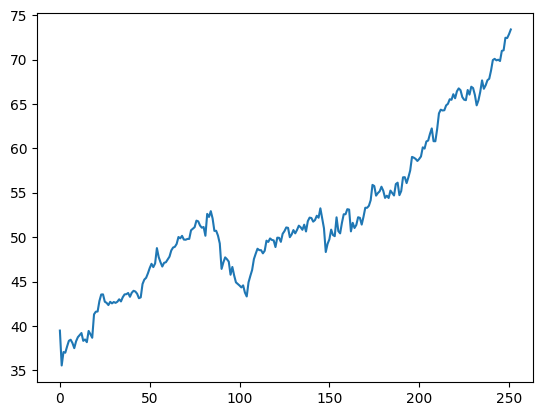

In [9]:
apple_test = Data_Utils.StockDataUtils(['AAPL'],'2019-01-01','2020-01-01')
apple_test.data.drop('Ticker',axis=1,inplace=True)
plt.plot(apple_test.data.index,apple_test.data['Close'])

In [10]:
apple_test.data

,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,...,others_dlr,others_cr,MA_5,MA_10,MA_15,MA_20,STD_20,RSI,Stochastic_Oscillator,Extremes
0,39.480000,37.893322,148158800,8.851008e+07,148158800,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,35.547501,34.118885,365248800,-2.394279e+08,-217090000,0.000000,0.000000e+00,-0.807149,0.000000,-3.638147e+07,...,-10.492436,-9.960737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,37.064999,35.575386,234428400,-3.362528e+07,17338400,0.000000,0.000000e+00,0.293167,0.000000,-2.637389e+07,...,4.180324,-6.117024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,36.982498,35.496201,219111200,5.087735e+07,-201772800,0.000000,0.000000e+00,0.099456,0.000000,-2.686159e+07,...,-0.222831,-6.325991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,37.687500,36.172878,164101200,1.085608e+08,-37671600,0.000000,0.000000e+00,0.352547,0.000000,-2.373331e+07,...,1.888370,-4.540272,37.352499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,71.067497,69.236229,48478800,2.256407e+09,2985867600,0.199718,2.827309e+07,0.405098,0.323932,4.360719e+07,...,0.095021,80.008860,70.373499,69.627998,68.642499,68.019249,1.921892,74.436586,97.202051,0
248,72.477501,70.609901,93121200,2.347059e+09,3078988800,0.255395,4.299140e+07,1.217283,0.367000,4.545474e+07,...,1.964609,83.580298,70.881999,70.106499,69.111999,68.339499,2.105315,78.678995,99.720753,0
249,72.449997,70.583107,146266000,2.284802e+09,2932722800,0.190868,3.627507e+07,0.926146,0.357786,4.539924e+07,...,-0.037955,83.510633,71.370999,70.564999,69.515666,68.613999,2.267631,78.405656,85.650331,0
250,72.879997,71.002045,144114400,2.383772e+09,3076837200,0.220169,3.994567e+07,-0.677078,0.336017,4.625458e+07,...,0.591759,84.599793,71.974998,70.974249,69.862499,68.917374,2.415013,79.598964,91.284202,0


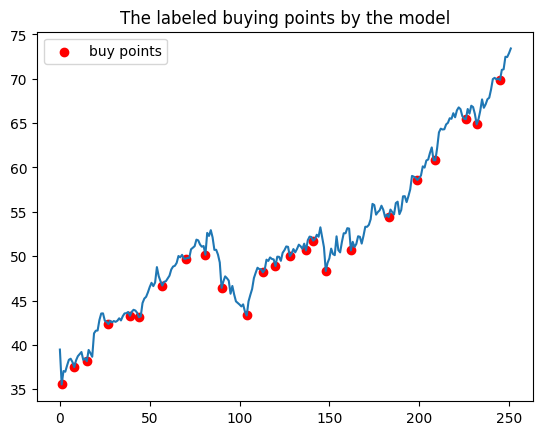

In [12]:
plt.plot(apple_test.data.index,apple_test.data['Close'])
plt.scatter(apple_test.buy_points_index,apple_test.data['Close'][apple_test.buy_points_index],color = 'red',label = 'buy points')
plt.title("The labeled buying points by the model")
plt.legend()

In [13]:
test_features = np.array(apple_test.data)[:,:-1]
test_labels = np.array(apple_test.data)[:,-1]

## Test and evaluate our models:

In [14]:
def find_buy_points(features,model,threshold=0.7):
    output = model.predict(features)
    res = (output >= threshold).astype(np.int64)
    return res

In [19]:
def evaluate_model(model, test_features, test_labels,use_throshold = False,threshold = 0.5):
    # Make predictions on the test set
    if use_throshold:
        predicted_proba = model.predict_proba(test_features)
        predictions = (predicted_proba [:,1] >= threshold).astype('int')
    else:
        predictions = model.predict(test_features)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    recall = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)
    conf_matrix = confusion_matrix(test_labels, predictions)
    roc_auc = roc_auc_score(test_labels, predictions)
    
    # Display the metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"ROC AUC Score: {roc_auc}")
    
    """
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'roc_auc': roc_auc
    }"""

## First model: Logistic regression

In [20]:
logistic_regression_model = sklearn.linear_model.LogisticRegression()

In [21]:
logistic_regression_model.fit(train_features,train_labels)

LogisticRegression()

In [22]:
evaluate_model(logistic_regression_model,test_features,test_labels)

Accuracy: 0.9047619047619048
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[228   0]
 [ 24   0]]
ROC AUC Score: 0.5


C:\Users\User\PycharmProjects\algotrade1\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that the logistic regression model can't deal succsucfuly with unbalanced dataset and it becomes classefire that takes everything to zero - every buy point is False negative

## Second model: Random forest

In [23]:
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(train_features,train_labels)

RandomForestClassifier(random_state=0)

In [24]:
evaluate_model(random_forest,test_features,test_labels)

Accuracy: 0.9007936507936508
Precision: 0.3333333333333333
Recall: 0.041666666666666664
F1 Score: 0.07407407407407407
Confusion Matrix:
[[226   2]
 [ 23   1]]
ROC AUC Score: 0.5164473684210527


## We have a lot of False negative so we will try to lower the prediction threshold

In [25]:
evaluate_model(random_forest,test_features,test_labels,True,0.35)

Accuracy: 0.8888888888888888
Precision: 0.4375
Recall: 0.5833333333333334
F1 Score: 0.5
Confusion Matrix:
[[210  18]
 [ 10  14]]
ROC AUC Score: 0.7521929824561404


## checking buying points that we get from random forest

# Threshold = 0.5

In [26]:
pred_labels = random_forest.predict(test_features)
buying_index = np.where(pred_labels==1)

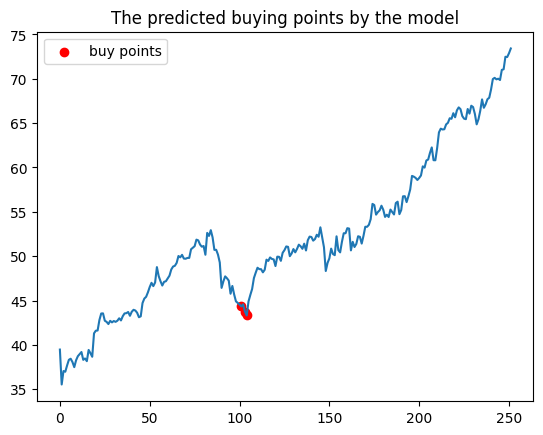

In [27]:
plt.plot(apple_test.data.index,apple_test.data['Close'])
plt.scatter(buying_index[0],apple_test.data['Close'][buying_index[0]],color = 'red',label = 'buy points')
plt.title("The predicted buying points by the model")
plt.legend()

# Threshold = 0.35


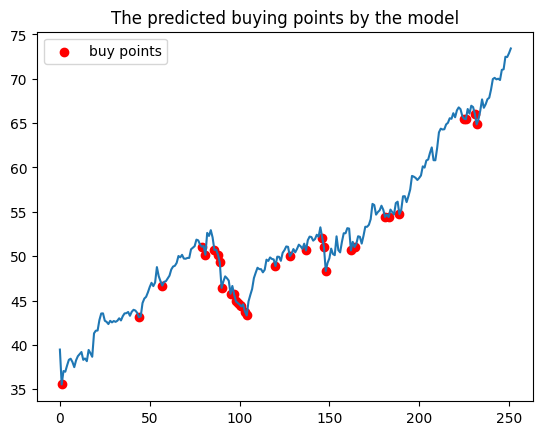

In [28]:
predicted_proba = random_forest.predict_proba(test_features)
pred_labels = (predicted_proba [:,1] >= 0.35).astype('int')
buying_index = np.where(pred_labels==1)
plt.plot(apple_test.data.index,apple_test.data['Close'])
plt.scatter(buying_index[0],apple_test.data['Close'][buying_index[0]],color = 'red',label = 'buy points')
plt.title("The predicted buying points by the model")
plt.legend()

With several adjustment to the threshold we can make the random forest algorithm predict buying points and lower the number of false negative.


## Third model: neural network

In [29]:
neural_network = nn_model.NeuralNetwork(96,[96,100,10,5,1])
neural_network.to(torch.float64)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): ReLU()
    (8): Linear(in_features=5, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [23]:
neural_network.train_model(torch.from_numpy(train_features),torch.from_numpy(train_labels),epochs=25)
torch.save(neural_network.state_dict(), "C:/Users/User/PycharmProjects/algotrade1/state_dict")


Epoch 1: Loss 0.1835844081168072
Epoch 2: Loss 0.1835825163134196
Epoch 3: Loss 0.18358062548442378
Epoch 4: Loss 0.18357873562951216
Epoch 5: Loss 0.1835768467483796
Epoch 6: Loss 0.18357495884072397
Epoch 7: Loss 0.18357307190624572
Epoch 8: Loss 0.18357118594464797
Epoch 9: Loss 0.18356930095563648
Epoch 10: Loss 0.1835649092455967
Epoch 11: Loss 0.1835605243118073
Epoch 12: Loss 0.18355864997012544
Epoch 13: Loss 0.18355677659404365
Epoch 14: Loss 0.18355490418328033
Epoch 15: Loss 0.1835530327375562
Epoch 16: Loss 0.18355116225659437
Epoch 17: Loss 0.1835492927401202
Epoch 18: Loss 0.18354742418786127
Epoch 19: Loss 0.18354555659954724
Epoch 20: Loss 0.18354368997491016
Epoch 21: Loss 0.18354182431368396
Epoch 22: Loss 0.18353995961560485
Epoch 23: Loss 0.18353809588041092
Epoch 24: Loss 0.1835362331078423
Epoch 25: Loss 0.18353189248712826


In [30]:
neural_network.load_state_dict(torch.load("C:/Users/User/PycharmProjects/algotrade1/state_dict"))

<All keys matched successfully>

In [31]:
evaluate_model(neural_network,test_features,test_labels)

Accuracy: 0.9047619047619048
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[228   0]
 [ 24   0]]
ROC AUC Score: 0.5


C:\Users\User\PycharmProjects\algotrade1\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusion

Although more research is required we can see that Tree-based models have better performance on our data since it is highly unbalanced.
We could try to match the quantity of every class but it will not reflect the situation in the stock market which is that most of the points are not a buy point.
The neural network and the logistic regression models probably learned mapping which is zero mapping since the data they were expose to is mostly zeros.
This is why we trained only 25 epoch the network.

Interesting direction to this project will be combining boosting algorithms like XGboost or try to model the problem in adifferent way so the data will be balanced and then using network or regression models